In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import njit
import numba

In [2]:
normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

@njit
def b_maxL_2(m, t, C):
    first = C[0]+C[1]-(m[0]+m[1])*(t[0]+t[1])
    root = (C[0]+C[1]+(m[0]-m[1])*(t[0]+t[1]))**2-4*C[0]*(m[0]-m[1])*(t[0]+t[1])
    res = (first+np.sqrt(root))/(2*(t[0]+t[1]))
    if res < 0:
        return 0
    return res

In [13]:
@njit
def interpolate_const(ys):
    return np.average(ys)

@njit
def interpolate_linear(ys, xs, x):
    idx = np.searchsorted(xs, x, side="left")
    if idx == 0:
        return ys[0]
    elif idx == len(xs):
        return ys[-1]
    else:
        return ys[idx-1] + (ys[idx] - ys[idx-1]) * (x - xs[idx-1]) / (xs[idx] - xs[idx-1])
    
@njit
def solve_quad_coef(xs, ys):
    A = np.array([[x**e for e in range(2,-1,-1)] for x in xs])
    print(A)
    inv = np.linalg.inv(A)
    return inv
    # return np.dot(inv, ys)
    
# @njit
def interpolate_quadratic(ys, xs, x):
    idx = np.searchsorted(xs, x, side="left")
    if idx == 0:
        return ys[0]
    elif idx == len(xs):
        return ys[-1]
    left_quad = True if idx > 1 else False
    right_quad = True if idx < len(xs)-1 else False
    
    
    res = 0.
    if left_quad:
        quad_xs = np.array([idx-2, idx-1, idx])
        coef = solve_quad_coef(quad_xs, ys[quad_xs])
        res += coef[0]*x**2 + coef[1]*x + coef[2]
    if right_quad:
        quad_xs = np.array([idx-1, idx, idx+1])
        coef = solve_quad_coef(quad_xs, ys[quad_xs])
        res += coef[0]*x**2 + coef[1]*x + coef[2]
    if left_quad and right_quad:
        res /= 2
    return res
    

In [14]:
solve_quad_coef(np.array([0,1,2]), np.array([0,1,4]))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(int64, 1d, C))
 
There are 16 candidate implementations:
[1m      - Of which 16 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(array(undefined, 1d, C), int64, array(int64, 1d, C))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of setitem at /tmp/ipykernel_10018/11607247.py (17)[0m
[1m
File "../../../../tmp/ipykernel_10018/11607247.py", line 17:[0m
[1m<source missing, REPL/exec in use?>[0m


In [103]:
xs = np.linspace(0, 10, 11)
ys = xs**2 + xs + 2
x = 10
print(interpolate_quadratic(ys, xs, x))
print(x**2 + x +2)

112.00000000000318
112


In [70]:
for i in range(2,-1,-1):
    print(i)

2
1
0


In [67]:
a = np.linspace(0, 10, 11)
np.searchsorted(a, 10.0, side="left")

10

In [145]:
# true incoming rates
s1 = 200.
s2 = 100.
b = 300.

# include time, even though rates = counts here, only included so that b_max_L doesn't have to be rewritten
t1 = 1.
t2 = 1.

true_counts = np.array([s1, s2, b, b])
cluster_size = 2

# How many posterior samples
num_posterior_samples = 300
# How many predictive samples, equivalent to number of real data bins in real analysis
num_predictive_samples = 1000
# Bins in plot
num_bins = 100

# standard deviation of posterior
posterior_std = np.array([0., 0.])
# samples of posterior
posterior_samples = np.random.normal(true_counts[:cluster_size], posterior_std, size=(num_posterior_samples, cluster_size))

# Each posterior sample is sampled into the predictive samples
posterior_predictive_source_counts = np.random.poisson(posterior_samples, (num_predictive_samples, num_posterior_samples, cluster_size))
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(0, 1)
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(1, 2)

# actual measured counts, available to use in analysis
measured_counts = np.random.poisson(true_counts, (num_predictive_samples, len(true_counts)))
measured_counts_combined = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

# maximum likelihood background
b_max_L = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_posterior_samples):
    for j in range(num_predictive_samples):
        b_max_L[j, i] = b_maxL_2(posterior_samples[i], [t1, t2], measured_counts_combined[j])
# n, bins, _ = plt.hist(b_max_L.flatten(), bins=num_bins)
# x = bins
# y = normal_dist(bins, b, np.sqrt(b))
# y = y * np.amax(n) / np.amax(y)
# plt.plot(x, y)


In [146]:
# Repeat for easier usage
posterior_predictive_background_counts = np.repeat(b_max_L[:,:,np.newaxis], 2, axis=2)
# Sample posterior predictive counts
posterior_predictive_counts = np.random.poisson(posterior_predictive_background_counts + posterior_predictive_source_counts)

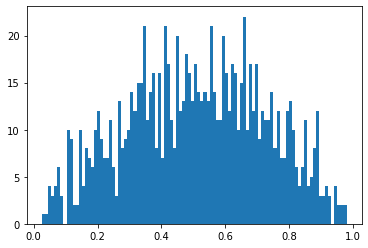

In [147]:
# Sort posterior predictive counts for each predictive sample, i.e. sort posterior samples
argsort = np.argsort(posterior_predictive_counts, axis=1)
total = np.take_along_axis(posterior_predictive_counts, argsort, axis=1)

# Find placement of measured counts in sorted array
cdf = np.zeros(num_predictive_samples)
for i in range(num_predictive_samples):
    cdf[i] = ((np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "left")
                     + np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "right"))
                     / (2 * num_posterior_samples))
    
_ = plt.hist(cdf, bins=num_bins)


In [4]:
@njit
def calc_bmaxL_variance_matrix(b_array, s1_array, t1_array, s2_array, t2_array, num_samples=1000000):
    variance_matrix = np.zeros((len(b_array), len(s1_array), len(t1_array), len(s2_array), len(t2_array), 2, 2, 2))
    for b_i, b in enumerate(b_array):
        for s1_i, s1 in enumerate(s1_array):
            for t1_i, t1 in enumerate(t1_array):
                for s2_i, s2 in enumerate(s2_array):
                    for t2_i, t2 in enumerate(t2_array):
                        print(b_i, s1_i, t1_i, s2_i, t2_i)
                        bd1 = np.zeros(num_samples)
                        bd2 = np.zeros(num_samples)
                        sd1 = np.zeros(num_samples)
                        sd2 = np.zeros(num_samples)
                        for n_i in range(num_samples):
                            s1m = np.random.poisson(t1 * s1)
                            s2m = np.random.poisson(t2 * s2)
                            b1m = np.random.poisson(t1 * b)
                            b2m = np.random.poisson(t2 * b)
                            
                            c1m = s1m + b1m
                            c2m = s2m + b2m
                            b_max_L = b_maxL_2(np.array([s1, s2]), np.array([t1, t2]), np.array([c1m, c2m]))
                            
                            bd1[n_i] = b1m - b_max_L*t1
                            bd2[n_i] = b2m - b_max_L*t2
                            sd1[n_i] = s1m - s1*t1
                            sd2[n_i] = s2m - s2*t2
                            
                        # if b_i == 0 and s1_i == 0 and s2_i == 0:
                        #     print(b, s1, t1, s2, t2)
                        #     print(s1m, s2m, b1m, b2m)
                        #     print([s1, s2], [t1, t2], [c1m, c2m])
                        #     print(b_maxL_2([s1, s2], [t1, t2], [c1m, c2m]))
                        #     print(b1m - b_max_L*t1, b2m - b_max_L*t2)
                        #     print(s1m - s1*t1, s2m - s2*t2)
                        #     print(np.cov(bd1, sd1))
                        variance_matrix[b_i, s1_i, t1_i, s2_i, t2_i, 0, :, :] = np.cov(bd1, sd1)
                        variance_matrix[b_i, s1_i, t1_i, s2_i, t2_i, 1, :, :] = np.cov(bd2, sd2)
                        
    return variance_matrix

In [4]:
input_b = np.geomspace(0.1,100,3)
input_s1 = np.geomspace(0.01,10,3)
input_t1 = np.geomspace(600, 6000, 3)
input_s2 = np.geomspace(0.01,10,3)
input_t2 = np.geomspace(600, 6000, 3)

In [5]:
v = calc_bmaxL_variance_matrix(input_b, input_s1, input_t1, input_s2, input_t2)

0 0 0 0 0
0 0 0 0 1
0 0 0 0 2
0 0 0 1 0
0 0 0 1 1
0 0 0 1 2
0 0 0 2 0
0 0 0 2 1
0 0 0 2 2
0 0 1 0 0
0 0 1 0 1
0 0 1 0 2
0 0 1 1 0
0 0 1 1 1
0 0 1 1 2
0 0 1 2 0
0 0 1 2 1
0 0 1 2 2
0 0 2 0 0
0 0 2 0 1
0 0 2 0 2
0 0 2 1 0
0 0 2 1 1
0 0 2 1 2
0 0 2 2 0
0 0 2 2 1
0 0 2 2 2
0 1 0 0 0
0 1 0 0 1
0 1 0 0 2
0 1 0 1 0
0 1 0 1 1
0 1 0 1 2
0 1 0 2 0
0 1 0 2 1
0 1 0 2 2
0 1 1 0 0
0 1 1 0 1
0 1 1 0 2
0 1 1 1 0
0 1 1 1 1
0 1 1 1 2
0 1 1 2 0
0 1 1 2 1
0 1 1 2 2
0 1 2 0 0
0 1 2 0 1
0 1 2 0 2
0 1 2 1 0
0 1 2 1 1
0 1 2 1 2
0 1 2 2 0
0 1 2 2 1
0 1 2 2 2
0 2 0 0 0
0 2 0 0 1
0 2 0 0 2
0 2 0 1 0
0 2 0 1 1
0 2 0 1 2
0 2 0 2 0
0 2 0 2 1
0 2 0 2 2
0 2 1 0 0
0 2 1 0 1
0 2 1 0 2
0 2 1 1 0
0 2 1 1 1
0 2 1 1 2
0 2 1 2 0
0 2 1 2 1
0 2 1 2 2
0 2 2 0 0
0 2 2 0 1
0 2 2 0 2
0 2 2 1 0
0 2 2 1 1
0 2 2 1 2
0 2 2 2 0
0 2 2 2 1
0 2 2 2 2
1 0 0 0 0
1 0 0 0 1
1 0 0 0 2
1 0 0 1 0
1 0 0 1 1
1 0 0 1 2
1 0 0 2 0
1 0 0 2 1
1 0 0 2 2
1 0 1 0 0
1 0 1 0 1
1 0 1 0 2
1 0 1 1 0
1 0 1 1 1
1 0 1 1 2
1 0 1 2 0
1 0 1 2 1
1 0 1 2 2
1 0 2 0 0


In [6]:
v[1,0,1,1,2,0,:,:]

array([[ 4.44896558e+03, -4.39584417e+00],
       [-4.39584417e+00,  1.90468154e+01]])

In [7]:
@njit
def calc_multivariate_normal(num_predictive_samples, num_posterior_samples, b_max_L, posterior_samples, v):
    posterior_predictive_counts = np.zeros((num_predictive_samples, num_posterior_samples))
    for i in range(num_predictive_samples):
        for j in range(num_posterior_samples):
            counts = np.random.multivariate_normal([b_max_L[i, j], posterior_samples[j, 0]], v[0,0,0,0,0,0,:,:])
            posterior_predictive_counts[i, j] = np.sum(counts)
    return posterior_predictive_counts

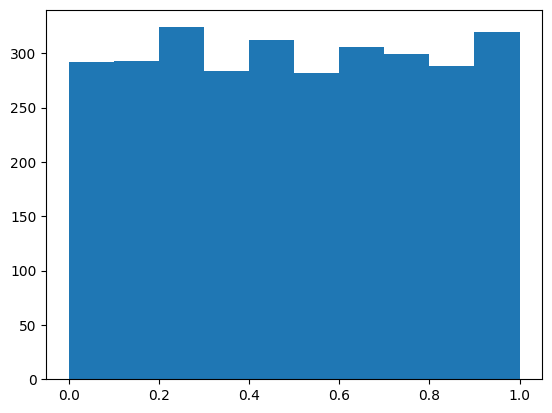

In [8]:
# true incoming rates
s1 = input_s1[0]
s2 = input_s2[1]
b = input_b[1]

# include time, even though rates = counts here, only included so that b_max_L doesn't have to be rewritten
t1 = input_t1[1]
t2 = input_t1[2]

times = np.array([t1, t2])

true_rates = np.array([s1, s2, b, b])
cluster_size = 2

# How many posterior samples
num_posterior_samples = 300
# How many predictive samples, equivalent to number of real data bins in real analysis
num_predictive_samples = 3000
# Bins in plot
num_bins = 10

# standard deviation of posterior
posterior_std = np.array([0.0, 0.0])
# samples of posterior
posterior_samples = np.random.normal(true_rates[:cluster_size], posterior_std, size=(num_posterior_samples, cluster_size))

# Each posterior sample is sampled into the predictive samples
posterior_predictive_source_counts = np.random.poisson(posterior_samples * times, (num_predictive_samples, num_posterior_samples, cluster_size))

# actual measured counts, available to use in analysis
measured_counts = np.random.poisson(true_rates * np.tile(times, 2), (num_predictive_samples, len(true_rates)))
measured_counts_combined = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

# maximum likelihood background
b_max_L = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_posterior_samples):
    for j in range(num_predictive_samples):
        b_max_L[j, i] = b_maxL_2(posterior_samples[i], times, measured_counts_combined[j])
# n, bins, _ = plt.hist(b_max_L.flatten(), bins=num_bins)
# x = bins
# y = normal_dist(bins, b, v[2,2,0,2,0])
# y = y * np.amax(n) / np.amax(y)
# plt.plot(x, y)

# print(np.var(b_max_L - b))
# print(v[2, 2, 0, 2, 0])



posterior_predictive_counts = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_predictive_samples):
    for j in range(num_posterior_samples):
        counts = np.random.multivariate_normal([b_max_L[i, j]*t1, posterior_samples[j, 0]*t1], v[1,0,1,1,2,0,:,:])
        # print([b_max_L[i, j], posterior_samples[j, 0]])
        # print(v[0,0,0,0,0,0,:,:])
        # print(counts)
        # print()
        posterior_predictive_counts[i, j] = np.sum(counts)
        


# # Repeat for easier usage
# posterior_predictive_background_counts = np.repeat(b_max_L[:,:,np.newaxis], 2, axis=2)
# # Sample posterior predictive counts
# posterior_predictive_counts = np.random.poisson(posterior_predictive_background_counts + posterior_predictive_source_counts)
# Sort posterior predictive counts for each predictive sample, i.e. sort posterior samples
argsort = np.argsort(posterior_predictive_counts, axis=1)
total = np.take_along_axis(posterior_predictive_counts, argsort, axis=1)

# Find placement of measured counts in sorted array
cdf = np.zeros(num_predictive_samples)
for i in range(num_predictive_samples):
    cdf[i] = ((np.searchsorted(total[i,:], measured_counts_combined[i, 0], "left")
                     + np.searchsorted(total[i,:], measured_counts_combined[i, 0], "right"))
                     / (2 * num_posterior_samples))
    
_ = plt.hist(cdf, bins=num_bins)




In [6]:
input_b = np.geomspace(0.1,100,20)
input_s1 = np.geomspace(0.01,10,20)
input_t1 = np.geomspace(600, 6000, 20)
input_s2 = np.geomspace(0.01,10,20)
input_t2 = np.geomspace(600, 6000, 20)

In [10]:
v_b = calc_bmaxL_variance_matrix(
    np.array(input_b),
    np.array([input_s1[10]]),
    np.array([input_t1[10]]),
    np.array([input_s2[5]]),
    np.array([input_t2[6]])
)

0 0 0 0 0
1 0 0 0 0
2 0 0 0 0
3 0 0 0 0
4 0 0 0 0
5 0 0 0 0
6 0 0 0 0
7 0 0 0 0
8 0 0 0 0
9 0 0 0 0
10 0 0 0 0
11 0 0 0 0
12 0 0 0 0
13 0 0 0 0
14 0 0 0 0
15 0 0 0 0
16 0 0 0 0
17 0 0 0 0
18 0 0 0 0
19 0 0 0 0


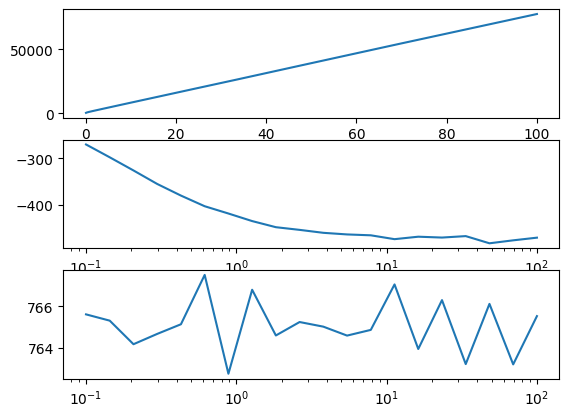

In [47]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(input_b, v_b[:,0,0,0,0,0,0,0])
ax[1].plot(input_b, v_b[:,0,0,0,0,0,1,0])
ax[2].plot(input_b, v_b[:,0,0,0,0,0,1,1])

# ax[0].set_xscale("log")
ax[1].set_xscale("log")
# ax[1].set_xscale("symlog")
ax[2].set_xscale("log")

In [17]:
v_s1 = calc_bmaxL_variance_matrix(
    np.array([input_b[12]]),
    np.array(input_s1),
    np.array([input_t1[10]]),
    np.array([input_s2[5]]),
    np.array([input_t2[6]])
)

0 0 0 0 0
0 1 0 0 0
0 2 0 0 0
0 3 0 0 0
0 4 0 0 0
0 5 0 0 0
0 6 0 0 0
0 7 0 0 0
0 8 0 0 0
0 9 0 0 0
0 10 0 0 0
0 11 0 0 0
0 12 0 0 0
0 13 0 0 0
0 14 0 0 0
0 15 0 0 0
0 16 0 0 0
0 17 0 0 0
0 18 0 0 0
0 19 0 0 0


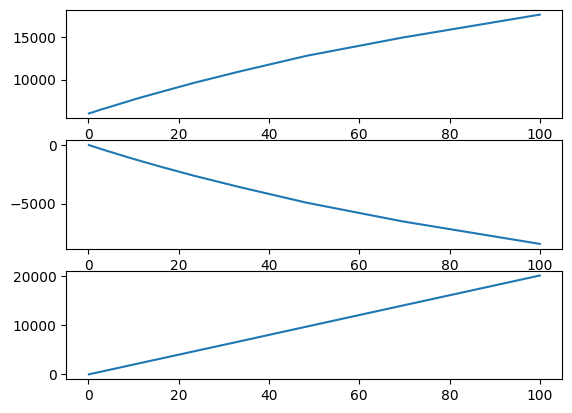

In [19]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(input_b, v_s1[0,:,0,0,0,0,0,0])
ax[1].plot(input_b, v_s1[0,:,0,0,0,0,1,0])
ax[2].plot(input_b, v_s1[0,:,0,0,0,0,1,1])

# ax[0].set_xscale("log")
# ax[1].set_xscale("log")
# ax[2].set_xscale("log")

In [20]:
v_t1 = calc_bmaxL_variance_matrix(
    np.array([input_b[12]]),
    np.array([input_s1[10]]),
    np.array(input_t1),
    np.array([input_s2[5]]),
    np.array([input_t2[6]])
)

0 0 0 0 0
0 0 1 0 0
0 0 2 0 0
0 0 3 0 0
0 0 4 0 0
0 0 5 0 0
0 0 6 0 0
0 0 7 0 0
0 0 8 0 0
0 0 9 0 0
0 0 10 0 0
0 0 11 0 0
0 0 12 0 0
0 0 13 0 0
0 0 14 0 0
0 0 15 0 0
0 0 16 0 0
0 0 17 0 0
0 0 18 0 0
0 0 19 0 0


[  -71.81713315   -88.20870992  -110.04423954  -132.99645254
  -159.71634215  -191.98398507  -231.71509846  -276.35253736
  -329.57514804  -396.31688405  -467.69293025  -555.94020151
  -648.07920572  -757.78185126  -892.47322981 -1044.41091155
 -1205.90706814 -1404.2965434  -1620.12863321 -1865.19101398]


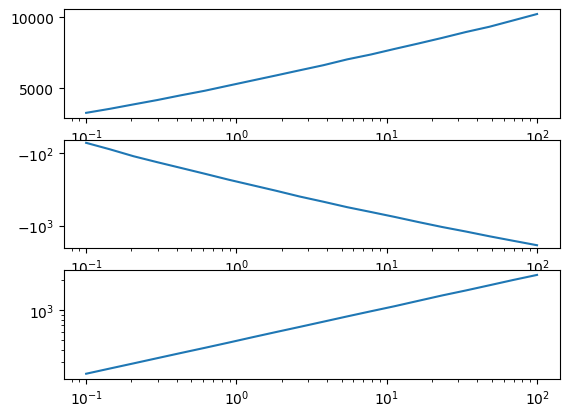

In [34]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(input_b, v_t1[0,0,:,0,0,0,0,0])
ax[1].plot(input_b, v_t1[0,0,:,0,0,0,1,0])
ax[2].plot(input_b, v_t1[0,0,:,0,0,0,1,1])

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("symlog")
ax[1].set_ylim(1.1*np.amin(v_t1[0,0,:,0,0,0,1,0]), 0.9*np.amax(v_t1[0,0,:,0,0,0,1,0]))
ax[2].set_xscale("log")
ax[2].set_yscale("log")
print(v_t1[0,0,:,0,0,0,1,0])

In [7]:
v_s2 = calc_bmaxL_variance_matrix(
    np.array([input_b[12]]),
    np.array([input_s1[10]]),
    np.array([input_t1[10]]),
    np.array(input_s2),
    np.array([input_t2[6]])
)

0 0 0 0 0
0 0 0 1 0
0 0 0 2 0
0 0 0 3 0
0 0 0 4 0
0 0 0 5 0
0 0 0 6 0
0 0 0 7 0
0 0 0 8 0
0 0 0 9 0
0 0 0 10 0
0 0 0 11 0
0 0 0 12 0
0 0 0 13 0
0 0 0 14 0
0 0 0 15 0
0 0 0 16 0
0 0 0 17 0
0 0 0 18 0
0 0 0 19 0


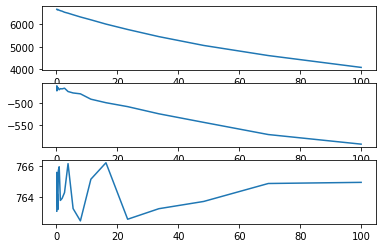

In [8]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(input_b, v_s2[0,0,0,:,0,0,0,0])
ax[1].plot(input_b, v_s2[0,0,0,:,0,0,1,0])
ax[2].plot(input_b, v_s2[0,0,0,:,0,0,1,1])

# ax[0].set_xscale("log")
# ax[1].set_xscale("log")
# ax[2].set_xscale("log")

In [39]:
v_t2 = calc_bmaxL_variance_matrix(
    np.array([input_b[12]]),
    np.array([input_s1[10]]),
    np.array([input_t1[10]]),
    np.array([input_s2[5]]),
    np.array(input_t2)
)

0 0 0 0 0
0 0 0 0 1
0 0 0 0 2
0 0 0 0 3
0 0 0 0 4
0 0 0 0 5
0 0 0 0 6
0 0 0 0 7
0 0 0 0 8
0 0 0 0 9
0 0 0 0 10
0 0 0 0 11
0 0 0 0 12
0 0 0 0 13
0 0 0 0 14
0 0 0 0 15
0 0 0 0 16
0 0 0 0 17
0 0 0 0 18
0 0 0 0 19


[-582.62968196]


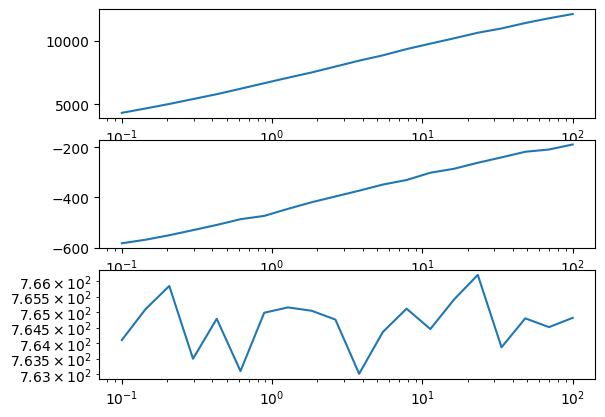

In [42]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(input_b, v_t2[0,0,0,0,:,0,0,0])
ax[1].plot(input_b, v_t2[0,0,0,0,:,0,1,0])
ax[2].plot(input_b, v_t2[0,0,0,0,:,0,1,1])

ax[0].set_xscale("log")
ax[1].set_xscale("log")
# ax[1].set_yscale("symlog")
# ax[1].set_ylim(1.1*np.amin(v_t2[0,0,:,0,0,0,1,0]), 0.9*np.amax(v_t2[0,0,:,0,0,0,1,0]))
ax[2].set_xscale("log")
ax[2].set_yscale("log")